# **Instaling Prerequisites**

In [ ]:
#pip install --extra-index-url https://test.pypi.org/simple/ decile-distil
!git clone https://github.com/decile-team/distil.git
!git clone https://github.com/decile-team/datasets.git
!pip install apricot-select

Cloning into 'distil'...
remote: Enumerating objects: 655, done.
remote: Counting objects: 100% (655/655), done.
remote: Compressing objects: 100% (414/414), done.
remote: Total 655 (delta 319), reused 547 (delta 223), pack-reused 0
Receiving objects: 100% (655/655), 13.16 MiB | 23.52 MiB/s, done.
Resolving deltas: 100% (319/319), done.
     |████████████████████████████████| 61kB 3.7MB/s 
     |████████████████████████████████| 163kB 9.8MB/s 


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import torch
import torch.optim as optim
from torch.autograd import Variable
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from copy import deepcopy

from distil.distil.utils.data_handler import DataHandler_Points
from distil.distil.active_learning_strategies.entropy_sampling import EntropySampling 
from distil.distil.active_learning_strategies.badge import BADGE
from distil.distil.active_learning_strategies.glister import GLISTER
from distil.distil.active_learning_strategies.random_sampling import RandomSampling
from distil.distil.utils.models.simple_net import TwoLayerNet
from matplotlib import pyplot as plt

### **Loading data**
IJCNN1 is a binary classification Dataset with 49,990 samples and 22 features. The following code snippet can be used to read datasets in the svmlight / libsvm format into numpy arrays.

In [ ]:
def libsvm_file_load(path,dim, save_data=False):
    data = []
    target = []
    with open(path) as fp:
       line = fp.readline()
       while line:
        temp = [i for i in line.strip().split(" ")]
        target.append(int(float(temp[0]))) # Class Number. # Not assumed to be in (0, K-1)
        temp_data = [0]*dim
        
        for i in temp[1:]:
            ind,val = i.split(':')
            temp_data[int(ind)-1] = float(val)
        data.append(temp_data)
        line = fp.readline()
    X_data = np.array(data,dtype=np.float32)
    Y_label = np.array(target)
    if save_data:
        # Save the numpy files to the folder where they come from
        data_np_path = path + '.data.npy'
        target_np_path = path + '.label.npy'
        np.save(data_np_path, X_data)
        np.save(target_np_path, Y_label)
    return (X_data, Y_label)

    
trn_file = 'datasets/ijcnn1/ijcnn1.trn'
val_file = 'datasets/ijcnn1/ijcnn1.val'
tst_file = 'datasets/ijcnn1/ijcnn1.tst'
data_dims = 22
num_cls = 2
x_trn, y_trn = libsvm_file_load(trn_file, dim=data_dims)
x_val, y_val = libsvm_file_load(val_file, dim=data_dims)
x_tst, y_tst = libsvm_file_load(tst_file, dim=data_dims)

# The class labels are (-1,1). Make them to (0,1)
y_trn[y_trn < 0] = 0
y_val[y_val < 0] = 0
y_tst[y_tst < 0] = 0    

sc = StandardScaler()
x_trn = sc.fit_transform(x_trn)
x_val = sc.transform(x_val)
x_tst = sc.transform(x_tst)


# **Class for training**

Although in this tutorial we mimic real world active learning setting with datasets which has all the labels, usually in a active learning settings it may take quite some time to label new set points. Therefore it is a good idea to create training class which can store current model state which can be restored later.

In [ ]:
def init_weights(m):
    torch.manual_seed(42)
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class data_train:

    def __init__(self, X, Y, net, handler, args):

        self.X = X
        self.Y = Y
        self.net = net
        self.handler = handler
        self.args = args
        self.use_cuda = torch.cuda.is_available()

    def update_index(self, idxs_lb):
        self.idxs_lb = idxs_lb

    def update_data(self, X, Y):
      
      self.X = X
      self.Y = Y
      self.n_pool = len(Y)

    def _train(self, epoch, loader_tr, optimizer):
        self.clf.train()
        accFinal = 0.

        for batch_id, (x, y, idxs) in enumerate(loader_tr):
            if self.use_cuda:
                x, y = Variable(x.cuda()), Variable(y.cuda())
            else:
                x, y = Variable(x), Variable(y)
            optimizer.zero_grad()
            out = self.clf(x)
            loss = F.cross_entropy(out, y)
            accFinal += torch.sum((torch.max(out,1)[1] == y).float()).data.item()
            loss.backward()

            # clamp gradients, just in case
            # for p in filter(lambda p: p.grad is not None, self.clf.parameters()): p.grad.data.clamp_(min=-.1, max=.1)

            optimizer.step()
        return accFinal / len(loader_tr.dataset.X)

    
    def train(self):

        #print('Training..')
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

        n_epoch = self.args['n_epoch']
        if self.use_cuda:
            self.clf =  self.net.apply(weight_reset).cuda()
        else:
            self.clf =  self.net.apply(weight_reset)

        optimizer = optim.Adam(self.clf.parameters(), lr = self.args['lr'], weight_decay=0)
        loader_tr = DataLoader(self.handler(self.X, self.Y, False),shuffle=True, batch_size = args['batch_size'])
        epoch = 1
        accCurrent = 0
        while accCurrent < 0.95 and epoch < n_epoch: 
            accCurrent = self._train(epoch, loader_tr, optimizer)
            epoch += 1
            # print(str(epoch) + ' training accuracy: ' + str(accCurrent), flush=True)
            
            if (epoch % 50 == 0) and (accCurrent < 0.2): # resetif not converging
                self.clf = self.net.apply(weight_reset)
                optimizer = optim.Adam(self.clf.parameters(), lr = self.args['lr'], weight_decay=0)

        print('Training accuracy:',round(accCurrent, 3)*100, flush=True) #'Epoch:', str(epoch),
        return self.clf

# **Trainig loop for active learning**

In [ ]:
def training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=False):

    flag = False
    if first:

      nSamps, dim = np.shape(X_unlabeled)

      np.random.seed(42)
      start_idxs = np.random.choice(nSamps, size=int(0.01*nSamps), replace=False)

      X_tr = X_unlabeled[start_idxs]
      X_unlabeled = np.delete(X_unlabeled, start_idxs, axis = 0)

      Y_tr = Y_unlabeled[start_idxs]
      Y_unlabeled = np.delete(Y_unlabeled, start_idxs, axis = 0)

      print('Starting set of points -', len(start_idxs))

    else:    

      #Human In Loop, Assuming user adds new labels here
      idx = strategy.select(budget)
      
      #Adding new points to training set
      X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
      X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

      Y_tr = np.concatenate((Y_tr, Y_unlabeled[idx]), axis = 0)
      Y_unlabeled = np.delete(Y_unlabeled, idx, axis = 0)

      print('Number of training points -',X_tr.shape[0])
    
    strategy.update_data(X_tr, Y_tr, X_unlabeled)
    dt.update_data(X_tr, Y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    y_pred = strategy.predict(x_tst).numpy()
    acc = round(1.0 * (y_tst == y_pred).sum().item() / len(y_tst), 3)
    #print('Testing accuracy:', acc, flush=True)
    if acc > 0.98:
        flag = True
        print('Testing accuracy reached above 98%')

    return X_tr,Y_tr,X_unlabeled,Y_unlabeled,acc, flag

# **Random**
This strategy is often used as a baseline, where we pick a set of unlabled points randomly. Here we create a instance of distil.active_learning_strategies.random_sampling.RandomSampling by passig following parameters:

**X (Numpy array)** – Features of the labled set of points

**Y (Numpy array)** – Lables of the labled set of points

**unlabeled_x (Numpy array)** – Features of the unlabled set of points

**net (class object)** – Model architecture used for training. Could be instance of models defined in distil.utils.models or something similar.

**handler (class object)** – It should be a subclass of torch.utils.data.Dataset i.e, have __getitem__ and __len__ methods implemented, so that is could be passed to pytorch DataLoader.Could be instance of handlers defined in distil.utils.DataHandler or something similar.

**nclasses (int)** – No. of classes in tha dataset

**args (dictionary)**– This dictionary should have ‘batch_size’ as a key. 'batch_size' should be such that one can exploit the benefits of tensorization while honouring the resourse constraits. This ‘batch_size’ therefore can be different than the one used for training.

We initally pass None for X,Y and unlabeled_x. Later we update using update functions of training class and RandomSampling class. 


In [ ]:
net = TwoLayerNet(data_dims, num_cls,40)
net.apply(init_weights)

strategy_args = {'batch_size' : 1000} 
strategy = RandomSampling(None, None, None, net, DataHandler_Points, num_cls, strategy_args)

args = {'n_epoch':150, 'lr':float(0.001),'batch_size':300}  #Different args than strategy_args
n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0])    ##Number of new data points after every iteration

#Training Class initialization
dt = data_train(None, None, net, DataHandler_Points, args)

rand_acc = np.zeros(n_rounds+1)
X_unlabeled = deepcopy(x_trn)
Y_unlabeled = deepcopy(y_trn)
X_tr = None
Y_tr = None

X_tr,Y_tr,X_unlabeled,Y_unlabeled,rand_acc[0],_ = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=True)
print('Initial Testing accuracy:', round(rand_acc[0], 3)*100, flush=True)

for i in range(n_rounds):
   print('-------------------------------------------------')
   print('Round', i+1) 
   print('-------------------------------------------------')
   
   X_tr,Y_tr,X_unlabeled,Y_unlabeled,rand_acc[i+1],flag = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst)
   print('Testing accuracy at',i+1,'round :', round(rand_acc[i+1], 3)*100, flush=True)  
   
   if flag:
     break


Starting set of points - 350
Training accuracy: 93.4
Initial Testing accuracy: 91.4
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 700
Training accuracy: 95.0
Testing accuracy at 1 round : 91.8
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 1050
Training accuracy: 95.1
Testing accuracy at 2 round : 92.30000000000001
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 1400
Training accuracy: 95.19999999999999
Testing accuracy at 3 round : 92.10000000000001
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 1750
Training accuracy: 95.0
Testing accuracy at 4 round : 91.8
-------------------------------------------------
Round 5
--------------------

# **Uncertanity based Active learning Strategy**

The most basic active learning strategy, where we select samples about which the model is most uncertain. To quantify the uncertainity we use entropy, therefore select points which have maximum entropy. Let $z_i$ be output from the model then the correponding softmax would be $$\sigma(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}$$. Then entropy can be calculated as, $$ENTROPY = -\sum_j \sigma(z_j)*log(\sigma(z_i))$$

Here we create a instance of distil.active_learning_strategies.entropy_sampling.EntropySampling with same parameters passed to distil.active_learning_strategies.random_sampling.RandomSampling.

In [ ]:
net = TwoLayerNet(data_dims, num_cls,40)
net.apply(init_weights)

strategy_args = {'batch_size' : 1000} 
strategy = EntropySampling(None, None, None, net, DataHandler_Points, num_cls, strategy_args)

args = {'n_epoch':150, 'lr':float(0.001),'batch_size':300}  #Different args than strategy_args
n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0])    ##Number of new data points after every iteration

#Training Class initialization
dt = data_train(None, None, net, DataHandler_Points, args)

un_acc = np.zeros(n_rounds+1)
X_unlabeled = deepcopy(x_trn)
Y_unlabeled = deepcopy(y_trn)
X_tr = None
Y_tr = None

X_tr,Y_tr,X_unlabeled,Y_unlabeled,un_acc[0],_ = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=True)
print('Initial Testing accuracy:', round(un_acc[0], 3)*100, flush=True)

for i in range(n_rounds):
   print('-------------------------------------------------')
   print('Round', i+1) 
   print('-------------------------------------------------')
   
   X_tr,Y_tr,X_unlabeled,Y_unlabeled,un_acc[i+1],flag = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst)
   print('Testing accuracy at',i+1,'round :', round(un_acc[i+1], 3)*100, flush=True)  
   
   if flag:
     break


Starting set of points - 350
Training accuracy: 93.4
Initial Testing accuracy: 91.4
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 700
Training accuracy: 95.0
Testing accuracy at 1 round : 94.5
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 1050
Training accuracy: 95.0
Testing accuracy at 2 round : 95.8
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 1400
Training accuracy: 95.0
Testing accuracy at 3 round : 97.1
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 1750
Training accuracy: 95.0
Testing accuracy at 4 round : 97.6
-------------------------------------------------
Round 5
-------------------------------------------------
Number of

# **GLISTER**
This is implemetation of GLISTER-ACTIVE from the paper [GLISTER: Generalization based Data Subset Selection for Efficient and Robust Learning](https://arxiv.org/abs/2012.10630). GLISTER methods tries to solve a bi-level optimisation problem.
\begin{equation*}
\overbrace{\underset{{S \subseteq {\mathcal U}, |S| \leq k}}{\operatorname{argmax\hspace{0.7mm}}} LL_V(\underbrace{\underset{\theta}{\operatorname{argmax\hspace{0.7mm}}} LL_T( \theta, S)}_{inner-level}, {\mathcal V})}^{outer-level}
\end{equation*}
where is $S$ is set of points selected at each round,${\mathcal V}$ could be a dedicated validation set with labled points or could be union of labeled and unlabeled points with hypothesised labels, $k$ is the budget.
To set ${\mathcal V}$ to be validation set, while calling **GLISTER** class in the toolkit set _valid=TRUE_ and pass validation set otherwise set _valid=False_.

Solving this problem directly is almost impossible, therefore we resort to one-step approxiations.We start we $S^0$ as empty set and bulid it as $S^k = S^{k-1} \cup e$, where $e$ is $\underset{e}{\operatorname{argmax\hspace{0.7mm}}} G_{\theta}(e | S^k)$. We define,$$G_{\theta}(e | S^k) = LL_{V}(\theta^{k}, {\mathcal V})$$ and update $$\theta^k \leftarrow \theta^{k-1} -  \eta \nabla_{\theta} LL_T(\hat{\theta}, e)$$ where $\hat{\theta}$ is the parameters of the model at the begining of the selection.
To prevent overfitting, we can add regularizer to GLISTER, which can be set by **_typeOf_**. **_typeOf_** can be set to - **'none'**(which is default) for normal GLISTER,**'Rand'** for replacing **_lam_** fraction of points replaced by random points, **'Diversity'** adding diversity set function while computing gain and **'FacLoc'** adding Facility Location set function while computing gain. **_lam_** for both **'Diversity'** and **'FacLoc'** determines the weightage given to them while computing the gain.

Here we create a instance of distil.active_learning_strategies.glister.GLISTER( with same parameters passed to distil.active_learning_strategies.random_sampling.RandomSampling, we slight change that, **args** dictionary should have keys ‘batch_size’ and ‘lr’. ‘lr’ should be the learning rate used for training. In addition to those folowing additional parameters may be passed:

**valid (boolean)** – Whether validation set is passed or not

**X_val (Numpy array, optional)** – Features of the points in the validation set. Mandatory if valid=True.

**Y_val (Numpy array, optional)** – Lables of the points in the validation set. Mandatory if valid=True.

**loss_criterion (class object, optional)** – The type of loss criterion. Default is torch.nn.CrossEntropyLoss()

**typeOf (str, optional)** – Determines the type of regulariser to be used. Default is ‘none’. For random regulariser use ‘Rand’. To use Facility Location set functiom as a regulariser use ‘FacLoc’. To use Diversity set functiom as a regulariser use ‘Diversity’.

**lam (float, optional)** – Determines the amount of regularisation to be applied. Mandatory if is not typeOf=’none’ and by default set to None. For random regulariser use values should be between 0 and 1 as it determines fraction of points replaced by random points. For both ‘Diversity’ and ‘FacLoc’ lam determines the weightage given to them while computing the gain.

**kernel_batch_size (int, optional)** – For 'Diversity' and 'FacLoc' regualrizer versions, similarity kernel is to be computed, which entails creating a 3d torch tensor of dimenssions $kernel\_batch\_size^{2}*(feature\ dimenssion)$. Again kernel_batch_size should be such that one can exploit the benefits of tensorization while honouring the resourse constraits.

In [ ]:
net = TwoLayerNet(data_dims, num_cls,40)
net.apply(init_weights)

strategy_args = {'batch_size' : 12000, 'lr':float(0.001)} 
strategy = GLISTER(None, None, None, net, DataHandler_Points, num_cls, strategy_args,valid=False,typeOf='Diversity',lam=20)

args = {'n_epoch':150, 'lr':float(0.001),'batch_size':300}  #Different args than strategy_args
n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0])     ##Number of new data points after every iteration

#Training Class initialization
dt = data_train(None, None, net, DataHandler_Points, args)

glister_acc = np.zeros(n_rounds+1)
X_unlabeled = deepcopy(x_trn)
Y_unlabeled = deepcopy(y_trn)
X_tr = None
Y_tr = None

X_tr,Y_tr,X_unlabeled,Y_unlabeled,glister_acc[0],_ = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=True)
print('Initial Testing accuracy:', round(glister_acc[0], 3)*100, flush=True)

for i in range(n_rounds):
  
  print('-------------------------------------------------')
  print('Round', i+1) 
  print('-------------------------------------------------')

  X_tr,Y_tr,X_unlabeled,Y_unlabeled,glister_acc[i+1],flag = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst)
  print('Testing accuracy at',i+1,'round :', round(glister_acc[i+1], 3)*100, flush=True)  
  if flag:
    break


Starting set of points - 350
Training accuracy: 93.4
Initial Testing accuracy: 91.4
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 700
Training accuracy: 95.0
Testing accuracy at 1 round : 92.60000000000001
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 1050
Training accuracy: 94.19999999999999
Testing accuracy at 2 round : 94.69999999999999
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 1400
Training accuracy: 95.0
Testing accuracy at 3 round : 95.89999999999999
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 1750
Training accuracy: 93.30000000000001
Testing accuracy at 4 round : 96.39999999999999
---------------------------------------

# **BADGE**
This method is based on the paper [Deep Batch Active Learning by Diverse, Uncertain Gradient Lower Bounds](https://arxiv.org/abs/1906.03671). Here at each around of selection loss gradients are computed using the hypothesised lables. Then to points to be labled are selected by applying k-means++ on these loss gradients. 

Here we create a instance of distil.active_learning_strategies.badge.BADGE with same parameters passed to distil.active_learning_strategies.random_sampling.RandomSampling.

In [ ]:
net = TwoLayerNet(data_dims, num_cls,40)
net.apply(init_weights)

strategy_args = {'batch_size' : 12000} 
strategy = BADGE(None, None, None, net, DataHandler_Points, num_cls, strategy_args)

args = {'n_epoch':150, 'lr':float(0.001),'batch_size':300}  #Different args than strategy_args
n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0])     ##Number of new data points after every iteration

#Training Class initialization
dt = data_train(None, None, net, DataHandler_Points, args)

badge_acc = np.zeros(n_rounds+1)
X_unlabeled = deepcopy(x_trn)
Y_unlabeled = deepcopy(y_trn)
X_tr = None
Y_tr = None

X_tr,Y_tr,X_unlabeled,Y_unlabeled,badge_acc[0],_ = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=True)
print('Initial Testing accuracy:', round(badge_acc[0], 3)*100, flush=True)

for i in range(n_rounds):
  print('-------------------------------------------------')
  print('Round', i+1) 
  print('-------------------------------------------------')

  X_tr,Y_tr,X_unlabeled,Y_unlabeled,badge_acc[i+1],flag = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst)
  print('Testing accuracy at',i+1,'round :', round(badge_acc[i+1], 3)*100, flush=True)  
  if flag:
    break


Starting set of points - 350
Training accuracy: 93.4
Initial Testing accuracy: 91.4
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 700
Training accuracy: 94.0
Testing accuracy at 1 round : 94.1
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 1050
Training accuracy: 93.89999999999999
Testing accuracy at 2 round : 95.39999999999999
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 1400
Training accuracy: 94.6
Testing accuracy at 3 round : 96.2
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 1750
Training accuracy: 94.3
Testing accuracy at 4 round : 96.89999999999999
-------------------------------------------------
Round 5
--------------------

Text(0.5, 1.0, 'IJCNN1')

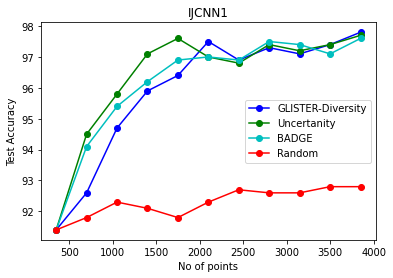

In [ ]:
x_axis = np.array([budget for i in range(n_rounds+1)])
x_axis = x_axis*np.array([i for i in range(1,n_rounds+2)])
plt.figure()
plt.plot(x_axis, glister_acc*100, 'b-', label='GLISTER-Diversity',marker='o')
plt.plot(x_axis, un_acc*100, 'g-', label='Uncertanity',marker='o')
plt.plot(x_axis, badge_acc*100, 'c', label='BADGE',marker='o')
plt.plot(x_axis, rand_acc*100, 'r', label='Random',marker='o')

plt.legend()
plt.xlabel('No of points')
plt.ylabel('Test Accuracy')
plt.title('IJCNN1')